In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [2]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

In [5]:
x_train.shape

(50000, 32, 32, 3)

In [7]:
# Hyper Paramters
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
image_size = 72
patch_size = 6
num_patch = (image_size // patch_size)**2
projection_dim = 64
num_heads = 4
transfomer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_heads_unit = [2048,1024]

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Patches layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [11]:
# Patch Encoder layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

In [57]:
def create_vit_classifier(image_size=32, patch_size=4, num_patches=64, projection_dim=64,
                          num_heads=4, transformer_layers=8, transformer_units=[128, 64], mlp_units=[2048, 1024], num_classes=10):

    # Input layer
    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Create patches
    patches = Patches(patch_size)(inputs)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple transformer layers
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = layers.Dense(transformer_units[0], activation=tf.nn.gelu)(x3)
        x3 = layers.Dense(transformer_units[1], activation=tf.nn.gelu)(x3)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a final layer normalization
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

    # Create a global average pooling layer
    representation = layers.GlobalAveragePooling1D()(representation)

    # MLP head for classification
    for units in mlp_units:
        representation = layers.Dense(units, activation=tf.nn.gelu)(representation)
        representation = layers.Dropout(0.1)(representation)

    # Create the final output layer
    logits = layers.Dense(num_classes)(representation)

    # Create the Keras model
    model = models.Model(inputs=inputs, outputs=logits)
    return model

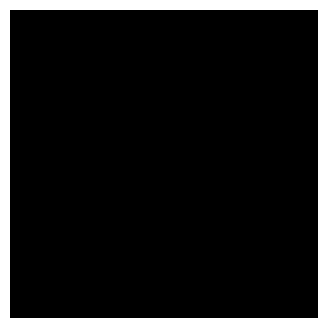

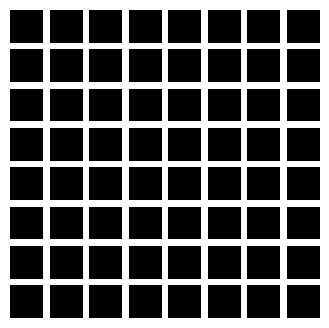

In [59]:
# Visualize patches
image_size = 32
patch_size = 4
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(x_train.shape[0])]
plt.imshow(image.astype('uint8'))
plt.axis("off")

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size=(image_size, image_size))
patches = Patches(patch_size)(resized_image)

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis("off")

In [61]:
def run_experiment(model, x_train, y_train, x_test, y_test, batch_size, num_epochs, learning_rate, weight_decay):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1)
    
    return history

# Define hyperparameters
num_epochs = 40
batch_size = 32
learning_rate = 0.001
weight_decay = 0.0001

In [63]:
# Create the Vision Transformer classifier
vit_classifier = create_vit_classifier()

# Run the experiment
history = run_experiment(vit_classifier, x_train, y_train, x_test, y_test, batch_size, num_epochs, learning_rate, weight_decay)

# Check the history object to see the training results
print(history.history)


Epoch 1/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 671s 446ms/step - accuracy: 0.2013 - loss: 2.0685 - val_accuracy: 0.3004 - val_loss: 1.8408
Epoch 2/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 635s 451ms/step - accuracy: 0.3321 - loss: 1.7161 - val_accuracy: 0.4100 - val_loss: 1.5503
Epoch 3/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 678s 448ms/step - accuracy: 0.4193 - loss: 1.5519 - val_accuracy: 0.4590 - val_loss: 1.4502
Epoch 4/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 619s 440ms/step - accuracy: 0.4659 - loss: 1.4450 - val_accuracy: 0.4744 - val_loss: 1.4095
Epoch 5/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 618s 439ms/step - accuracy: 0.5014 - loss: 1.3629 - val_accuracy: 0.5028 - val_loss: 1.3314
Epoch 6/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 632s 449ms/step - accuracy: 0.5234 - loss: 1.3056 - val_accuracy: 0.5280 - val_loss: 1.2877
Epoch 7/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 622s 442ms/step - accuracy: 0.5394 - loss: 1.2656 - val_accuracy: 0.5638 - val_loss: 1.2049
Epoch 8/40
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 627s 445ms/step - a